# Regresión logística multinomial

## Declaración de librerías

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import requests, gzip, os, hashlib
import time
from numpy import linalg as LA

## Funciones

In [2]:
# train_data, test_data, train_labels, test_labels = read_datasets(train_data_csv, test_data_csv)

def read_datasets(train_data_csv, test_data_csv):
    
    train_data = np.loadtxt(train_data_csv, delimiter=",")
    test_data = np.loadtxt(test_data_csv, delimiter=",") 

    train_labels = np.asfarray(train_data[:, :1])
    test_labels = np.asfarray(test_data[:, :1])
    
    return train_data, test_data, train_labels, test_labels;



# train_data, test_data = normalize_dataset(train_data, test_data, max_value)

def normalize_dataset(train_data, test_data, max_value):

    train_data = np.asfarray(train_data[:, 1:])/max_value
    test_data = np.asfarray(test_data[:, 1:])/max_value
    
    return train_data, test_data;



# display_data(dataset, index, m, n)

def display_data(dataset, index, m, n):
    
    image = dataset[index].reshape((m,n))
    plt.imshow(image)
    plt.show()



# train_labels_hot, test_labels_hot = onehot_dataset(train_labels, test_labels, n_classes)   
    
def onehot_dataset(train_labels, test_labels, labels_size):
    
    labels_vector = np.arange(labels_size)
    train_labels_hot = (labels_vector==train_labels).astype(float)
    test_labels_hot = (labels_vector==test_labels).astype(float)
    
    return train_labels_hot, test_labels_hot;



# Y_hot_hat = softmax(X, W)

def softmax(X, W, N, Z):
    
    Z_exp = np.exp(Z)
    Z_exp_sum = Z_exp.sum(axis=1).reshape([N,1])
    Y_hot_hat = Z_exp / Z_exp_sum[None,:]
    Y_hot_hat = Y_hot_hat[0]
    
    return Y_hot_hat;



# gradient = gradient_fun(X, Y_hot, Y_hot_hat, N)

def gradient_fun(X, Y_hot, Y_hot_hat, N):

    gradient = 1/N * (X.T @ (Y_hot - Y_hot_hat))
    
    return gradient;



# cost = cost_fun(X, Y_hot, W, N)

def cost_fun(X, Y_hot, W, N, Z):
    
    #cost[0] = 1/N * (np.trace(X.T @Y_hot  @ W.T) + np.sum(np.log(np.sum(np.exp(X @ W), axis=0))))
    #cost = 1/N * (np.sum(np.multiply(X,Y_hot@ W.T)) + np.sum(np.log(np.sum(np.exp(X @ W), axis=0))))
    cost = 1/N * (np.sum(np.multiply(X,W.T[Y[0,:].astype(int), :])) + np.sum(np.log(np.sum(np.exp(Z), axis=1))))
    #cost = 1/N * (np.sum(np.multiply(X,Y_hot@ W.T)) + np.sum(np.log(np.sum(np.exp(X @ W), axis=0))))
    #np.sum(np.multiply(X,Y_hot@ W.T))
    
    return cost;




# score_count = score_count_fun(Y, Y_hot_hat)

def score_count_fun(X, W, Y, N, Z): 
    
    #Y_hat = np.argmax(Y_hot_hat,axis=2 )
    Y_hot_hat = softmax(X, W, N, Z)
    Y_hat = np.argmax(Y_hot_hat,axis=1 )
    score_count = np.sum(Y == Y_hat)
    
    return score_count;




# accuaracy_fun(X, W, Y, N):

def accuaracy_fun(X, W, Y, N, Z): #Halla Z igual que en softmax (softmax lo hace con R), revisar
    
    score_count = score_count_fun(X, W, Y, N, Z)
    
    train_accuaracy = score_count/N
    
    print(train_accuaracy)
    

    
# plot_fun_1axis(data, xlabel, ylabel)

def plot_fun_1axis(data, xlabel, ylabel):
    
    plt.figure(1)
    plt.plot(data)
    plt.grid('on')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()
    


    
# plot_fun_1axis_log(data, xlabel, ylabel)
    
def plot_fun_1axis_log(data, xlabel, ylabel):
    
    plt.plot(data)
    plt.grid('on')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.yscale('log')
    plt.show()  
    


    
# plot_results_1axis_delay(data, delay,  N, xlabel, ylabel)

def plot_results_1axis_delay(data, delay,  N, xlabel, ylabel):
    
    plt.plot(data[delay:N])
    plt.grid('on')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()
    
    

    
# plot_fun_2axis(x_axis, y_axis, xlabel, ylabel)
    
def plot_fun_2axis(x_axis, y_axis, xlabel, ylabel):
    
    plt.plot(x_axis, y_axis)
    plt.grid('on')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()
  
    


    
# plot_result_2_fun(data1, data2)

def plot_result_2_fun(data1, data2, N_epochs):

    t = np.arange(N_epochs+1)

    fig, ax1 = plt.subplots()

    color = 'tab:red'
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Función de Costo', color=color)
    ax1.plot(t, data1, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx() 
    color = 'tab:blue'
    ax2.set_ylabel('Número de aciertos', color=color) 
    ax2.plot(t, data2, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()
    plt.show()




# test_data_hat_comparison(X, W, Y, index, m, n, k)
    
def test_data_hat_comparison(X, W, Y, index, m, n, k):
    

    test_vector = X[index,0:k]
    test = test_vector.reshape((m,n))

    plt.imshow(test)
    plt.show()

    y_hat = np.exp(-np.transpose(W).dot(test_vector))
    print(y_hat)
    print(np.argmax(y_hat))

    print(Y[0, index])

In [3]:
def multinominalLR_SGD(X, W, Y, N_epochs, n_blocks, k, L, r, alpha):
    
    cost = np.zeros([N_epochs+1,1])
    score_count = np.zeros([N_epochs+1,1])
    time_epoch = np.zeros([N_epochs+1,1])
    
    Z = -X @ W
    #Funcion de Costo
    cost[0] = cost_fun(X, Y_hot, W, N, Z)
    #Cuenta del Score
    score_count[0] = score_count_fun(X, W, Y, N, Z)

    #Tiempo
    time_epoch[0] = 0
    t = time.time()

    for i in range(N_epochs):
    
        R = np.random.permutation(N).reshape((r, n_blocks))

        for j in range(n_blocks):
        
            X_R  = X[R[:,j],:]
            Y_R_hot = Y_hot[R[:,j],:]
            Z_R = -X_R @ W
            Y_R_hot_hat = softmax(X_R, W, r, Z_R)
        
            #Gradiente
            gradient_R = gradient_fun(X_R, Y_R_hot, Y_R_hot_hat, r)   
            W = W - alpha*gradient_R
            
        #print(i)
        Z = -X @ W
        #Función de Costo
        cost[i+1] = cost_fun(X, Y_hot, W, N, Z)
    
        #Cuenta del Score
        score_count[i+1] = score_count_fun(X, W, Y, N, Z)
        
        time_epoch[i+1] = time.time() - t 
        
    return cost, score_count, time_epoch, W,X_R, gradient_R
    

## Función de Regresión Multinomial SGD ADAM

In [6]:
def multinominalLR_SGD_ADAM(X, W, Y, beta1, beta2, eps, N_epochs, n_blocks, k, L, r, alpha):

    cost = np.zeros([N_epochs+1,1])
    score_count = np.zeros([N_epochs+1,1])
    time_epoch = np.zeros([N_epochs+1,1])

    beta1_t = np.zeros([N_epochs*n_blocks+1,1])
    beta2_t = np.zeros([N_epochs*n_blocks+1,1])

    mt = np.zeros((k,L))
    vt = np.zeros((k,L))

    Z = -X @ W
    #Funcion de Costo
    cost[0] = cost_fun(X, Y_hot, W, N, Z)

    #Cuenta del Score
    score_count[0] = score_count_fun(X, W, Y, N, Z)

    #Tiempo
    time_epoch[0] = 0
    t = time.time()

    for i in range(N_epochs):
    
        R = np.random.permutation(N).reshape((r, n_blocks))

        for j in range(n_blocks):
        
            X_R  = X[R[:,j],:]
            Y_R_hot = Y_hot[R[:,j],:]
            Z_R = -X_R @ W
            Y_R_hot_hat = softmax(X_R, W, r, Z_R)
        
            #Gradiente
            gradient_R = gradient_fun(X_R, Y_R_hot, Y_R_hot_hat, r)   
        
            #ADAM
            mt = beta1*mt + (1-beta1)*gradient_R
            vt = beta2*vt + (1-beta2)*(gradient_R**2)

            #beta1_t = beta1**(i+1) #
            #beta2_t = beta2**(i+1)
        
            beta1_t = beta1**((n_blocks*i+(j+1))) 
            beta2_t = beta2**((n_blocks*i+(j+1)))      
        
            #print(n_blocks*i+(j+1))
        
            mhat_t = mt / (1-beta1_t)
            vhat_t = vt / (1-beta2_t)
        
            #alpha_t = alpha * np.sqrt(1-beta2_t) / (1-beta1_t) #1
            #W = W - alpha_t * mt / (np.sqrt(vt) + eps) #1
        
            W = W - alpha*mhat_t / (np.sqrt(vhat_t) + eps) #2
        

        #print(i)
        Z = -X @ W
        #Función de Costo
        cost[i+1] = cost_fun(X, Y_hot, W, N, Z)
    
        #Cuenta del Score
        score_count[i+1] = score_count_fun(X, W, Y, N, Z)
        
        time_epoch[i+1] = time.time() - t 
    
    return cost, score_count, time_epoch, W 

## Iniciacización de parámentros

In [7]:
data_len = 28
data_size = data_len*data_len
labels_size = 10
N = 60000
N_test = 10000

k = 28*28 #numero de features
L = 10 #numero de clases
N = 60000
W_init = np.random.random((k, L))/np.sqrt(k*L)
alpha_SGD = 0.001
alpha_SGD_ADAM = 0.001

#minlim = 0.0001
#maxlim = 0.1

maxlim = 1
auto_scale = 10**-3

sets_epoch = 0.01
R = int(sets_epoch*N)
N_epochs = 20
r = 100 #tamaño de bloque
n_blocks = int(N/r) #número de bloques

beta = 10/N_epochs
eta = 0.1

## Iniciacización de parámentros ADAM

In [8]:
#ADAM

beta1 = 0.9 #0.9 0.8
beta2 = 0.999 #0.999 0.899

eps = 10**-8

## Lectura del dataset

In [9]:
train_data_csv = "mnist_train.csv"
test_data_csv = "mnist_test.csv"

X, X_test, Y, Y_test = read_datasets(train_data_csv, test_data_csv)

# Normalizar dataset

max_value = 255.0
X, X_test = normalize_dataset(X, X_test, max_value)

# Representacoón one-hot

Y_hot, Y_hot_test = onehot_dataset(Y, Y_test, labels_size)
Y = np.transpose(Y)
Y_test = np.transpose(Y_test)

## Probar accuaracy previamente

Accuaracy:
0.11668333333333333


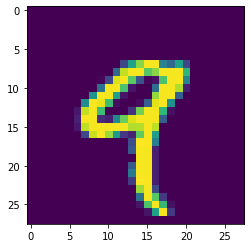

[0.62160735 0.60906425 0.582788   0.60548121 0.56662506 0.5941264
 0.62863372 0.63384155 0.59286009 0.61857791]
7
9.0


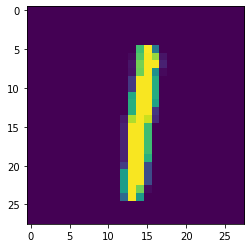

[0.75363517 0.72631436 0.72659746 0.73748208 0.70916114 0.71863515
 0.73549271 0.73255231 0.71381664 0.74311866]
0
1.0


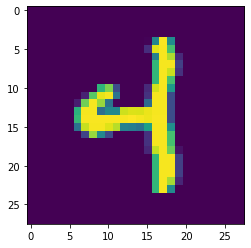

[0.63759616 0.64779607 0.61415599 0.61449496 0.57359788 0.61854083
 0.61342833 0.63842105 0.61005605 0.62316494]
1
4.0


In [10]:
print("Accuaracy:")
Z = -X @ W_init
accuaracy_fun(X, W_init, Y, N, Z)

test_data_hat_comparison(X, W_init, Y, 4, data_len, data_len, k)
test_data_hat_comparison(X, W_init, Y, 40, data_len, data_len, k)
test_data_hat_comparison(X, W_init, Y, 4240, data_len, data_len, k)

## Algoritmo SGD

In [11]:
cost_SGD, score_count_SGD, time_epoch_SGD, W_SGD, X_R, gradient_R = multinominalLR_SGD(X, W_init, Y, N_epochs, n_blocks, k, L, r, alpha_SGD)

## Algoritmo SGD con tamaño de paso automático

In [12]:
cost_SGD_auto, score_count_SGD_auto, time_epoch_SGD_auto, W_SGD_auto, alpha_auto = multinominalLR_SGD_auto(X, W_init, Y, N_epochs, n_blocks, k, L, r, alpha_SGD, auto_scale)

## Algoritmo SGD con tamaño de paso automático con límites

In [13]:
cost_SGD_auto_lim, score_count_SGD_auto_lim, time_epoch_SGD_auto_lim, W_SGD_auto_lim, alpha_auto_lim = multinominalLR_SGD_auto_lim(X, W_init, Y, N_epochs, n_blocks, k, L, r, alpha_SGD, maxlim, auto_scale)

## Algoritmo SGD ADAM

In [14]:
cost_SGD_ADAM, score_count_SGD_ADAM, time_epoch_SGD_ADAM, W_SGD_ADAM = multinominalLR_SGD_ADAM(X, W_init, Y, beta1, beta2, eps, N_epochs, n_blocks, k, L, r, alpha_SGD_ADAM)

## Probar accuaracy SGD

In [15]:
print("Accuaracy de train data:")
Z = -X @ W_SGD
accuaracy_fun(X, W_SGD, Y, N, Z)

Accuaracy de train data:
0.8648333333333333


Accuaracy de test data:
0.8749


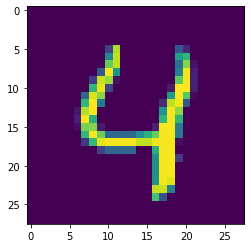

[ 0.4792543   0.01845967  1.15907732  0.18198727 13.52356994  0.27498833
  0.79920794  1.19577382  0.85920156  2.60344827]
4
4.0


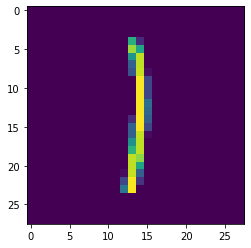

[ 0.25231023 13.45592862  0.93578198  0.98618607  0.30012814  0.67160793
  0.79496206  0.63847577  1.03550545  0.64083812]
1
1.0


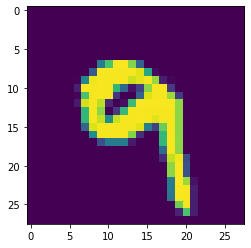

[ 0.03074587  0.07205452  0.08830152  0.33375441  7.19519745  0.75734214
  0.55545382  0.58133113  0.77057983 23.49059504]
9
9.0


In [16]:
print("Accuaracy de test data:")
Z_test = -X_test @ W_SGD
accuaracy_fun(X_test, W_SGD, Y_test, N_test, Z_test)

test_data_hat_comparison(X_test, W_SGD, Y_test, 4, data_len, data_len, k)
test_data_hat_comparison(X_test, W_SGD, Y_test, 40, data_len, data_len, k)
test_data_hat_comparison(X_test, W_SGD, Y_test, 4240, data_len, data_len, k)

## Probar accuaracy SGD con tamaño de paso automático

In [17]:
print("Accuaracy de train data:")
Z = -X @ W_SGD_auto
accuaracy_fun(X, W_SGD_auto, Y, N, Z)

Accuaracy de train data:
0.9062166666666667


Accuaracy de test data:
0.9109


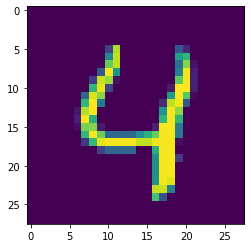

[2.23009703e-01 2.90023992e-03 1.15248684e+00 8.16168894e-02
 1.02636180e+02 1.06816604e-01 9.80763207e-01 1.73362804e+00
 1.90009339e+00 6.88484063e+00]
4
4.0


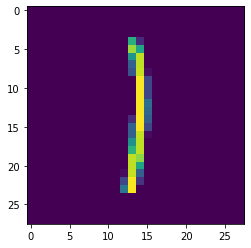

[5.57194807e-02 8.97984087e+01 1.36449605e+00 1.43669016e+00
 9.59894529e-02 5.33654306e-01 6.76131125e-01 4.80788407e-01
 1.80552645e+00 7.21294737e-01]
1
1.0


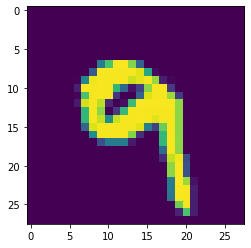

[1.08614849e-03 2.94347624e-02 3.12171121e-02 2.83185705e-01
 3.99635728e+01 8.62774510e-01 1.95381768e-01 4.33062568e-01
 4.13494175e+00 6.09932494e+02]
9
9.0


In [18]:
print("Accuaracy de test data:")
Z_test = -X_test @ W_SGD_auto
accuaracy_fun(X_test, W_SGD_auto, Y_test, N_test, Z_test)

test_data_hat_comparison(X_test, W_SGD_auto, Y_test, 4, data_len, data_len, k)
test_data_hat_comparison(X_test, W_SGD_auto, Y_test, 40, data_len, data_len, k)
test_data_hat_comparison(X_test, W_SGD_auto, Y_test, 4240, data_len, data_len, k)

## Probar accuaracy SGD ADAM

In [19]:
print("Accuaracy de train data:")
Z = -X @ W_SGD_ADAM
accuaracy_fun(X, W_SGD_ADAM, Y, N, Z)

Accuaracy de train data:
0.9325666666666667


Accuaracy de test data:
0.9265


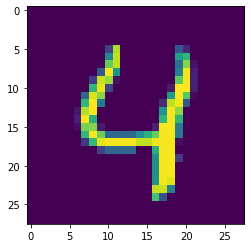

[6.48994546e-02 5.95633558e-06 1.89298194e-01 3.30959539e-03
 1.37985942e+02 4.95049454e-03 2.84985889e-01 2.14998457e-01
 9.88645056e-01 3.63907572e+00]
4
4.0


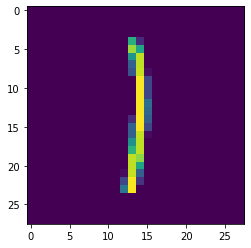

[1.40041902e-03 2.04046503e+02 9.60146031e-01 1.65055231e+00
 6.15336911e-03 1.79652679e-01 3.18198873e-01 2.32425831e-01
 1.14880555e+00 4.82755380e-01]
1
1.0


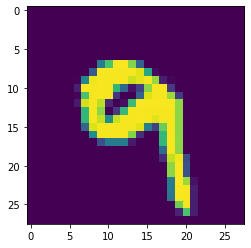

[1.66297350e-08 1.61687430e-03 1.24437243e-04 1.79704434e-02
 3.51936410e+00 2.02587464e-02 9.45671637e-05 6.45559542e-03
 3.21552285e-01 3.33826762e+02]
9
9.0


In [20]:
print("Accuaracy de test data:")
Z_test = -X_test @ W_SGD_ADAM
accuaracy_fun(X_test, W_SGD_ADAM, Y_test, N_test, Z_test)

test_data_hat_comparison(X_test, W_SGD_ADAM, Y_test, 4, data_len, data_len, k)
test_data_hat_comparison(X_test, W_SGD_ADAM, Y_test, 40, data_len, data_len, k)
test_data_hat_comparison(X_test, W_SGD_ADAM, Y_test, 4240, data_len, data_len, k)

## Gráficos de comparación con métodos adaptativos

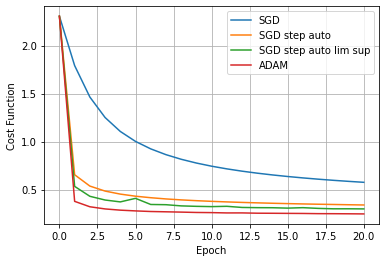

In [21]:
plt.plot(cost_SGD,label='SGD')
plt.plot(cost_SGD_auto,label='SGD step auto')
plt.plot(cost_SGD_auto_lim,label='SGD step auto lim sup')
plt.plot(cost_SGD_ADAM,label='ADAM')

plt.grid('on')
plt.xlabel('Epoch')
plt.ylabel('Cost Function')
plt.legend(loc='upper right')
plt.savefig('Cost1.png', dpi=300)
plt.show()

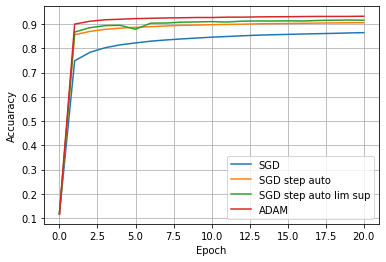

In [22]:
plt.plot(score_count_SGD/60000,label='SGD')
plt.plot(score_count_SGD_auto/60000,label='SGD step auto')
plt.plot(score_count_SGD_auto_lim/60000,label='SGD step auto lim sup')
plt.plot(score_count_SGD_ADAM/60000,label='ADAM')

plt.grid('on')
plt.xlabel('Epoch')
plt.ylabel('Accuaracy')
plt.legend(loc='lower right')
plt.savefig('Accuaracy1.png', dpi=300)
plt.show()

## Gráficos de comparación en el tiempo

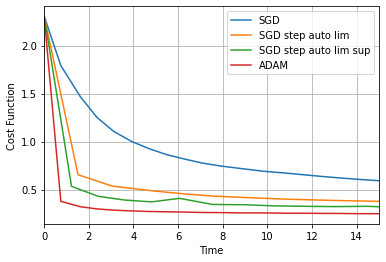

In [23]:
plt.plot(time_epoch_SGD, cost_SGD,label='SGD')
plt.plot(time_epoch_SGD_auto, cost_SGD_auto,label='SGD step auto lim')
plt.plot(time_epoch_SGD_auto_lim, cost_SGD_auto_lim,label='SGD step auto lim sup')
plt.plot(time_epoch_SGD, cost_SGD_ADAM,label='ADAM')


plt.grid('on')
plt.xlabel('Time')
plt.ylabel('Cost Function')
plt.legend(loc='upper right')
plt.xlim([0,15])
plt.savefig('TimeCost1.png', dpi=300)
plt.show()

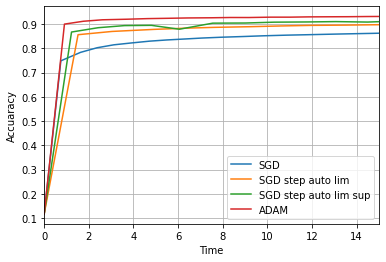

In [24]:
plt.plot(time_epoch_SGD, score_count_SGD/60000,label='SGD')
plt.plot(time_epoch_SGD_auto, score_count_SGD_auto/60000,label='SGD step auto lim')
plt.plot(time_epoch_SGD_auto_lim, score_count_SGD_auto_lim/60000,label='SGD step auto lim sup')
plt.plot(time_epoch_SGD_ADAM, score_count_SGD_ADAM/60000,label='ADAM')

plt.grid('on')
plt.xlabel('Time')
plt.ylabel('Accuaracy')
plt.legend(loc='lower right')
plt.xlim([0,15])
plt.savefig('TimeAccuaracy1.png', dpi=300)
plt.show()


## AUTO

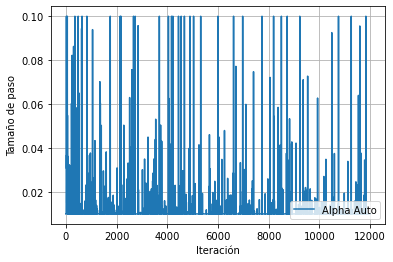

In [25]:
plt.plot(alpha_auto,label='Alpha Auto')

plt.grid('on')
plt.xlabel('Iteración')
plt.ylabel('Tamaño de paso')
plt.legend(loc='lower right')
plt.show()


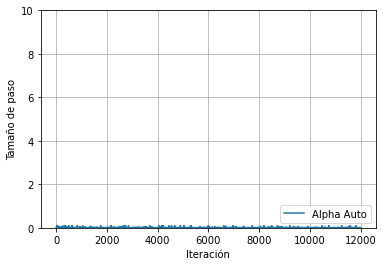

In [26]:
plt.plot(alpha_auto,label='Alpha Auto')

plt.grid('on')
plt.xlabel('Iteración')
plt.ylabel('Tamaño de paso')
plt.legend(loc='lower right')
plt.ylim(0, maxlim*10) 
plt.show()

In [27]:
## AUTO LIM

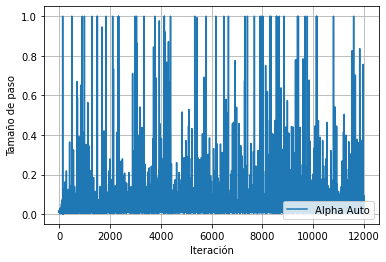

In [28]:
plt.plot(alpha_auto_lim,label='Alpha Auto')

plt.grid('on')
plt.xlabel('Iteración')
plt.ylabel('Tamaño de paso')
plt.legend(loc='lower right')
plt.show()


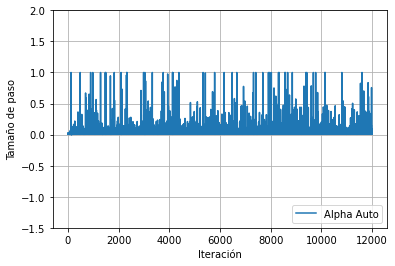

In [29]:
plt.plot(alpha_auto_lim,label='Alpha Auto')

plt.grid('on')
plt.xlabel('Iteración')
plt.ylabel('Tamaño de paso')
plt.legend(loc='lower right')
plt.ylim(-maxlim - maxlim/2, maxlim*2) 
plt.show()